# Kolmas neuroverkkokurssin menetelmätehtävä - Ville Kurikka



Aloitetaan lataamalla tarvittava datasetti, ja jakamalla se opetus-, validointi- ja testiosuuksiin.

In [1]:

import numpy as np
import keras

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
assert x_train.shape == (50000, 32, 32, 3)
assert x_test.shape == (10000, 32, 32, 3)
assert y_train.shape == (50000, 1)
assert y_test.shape == (10000, 1)

x_val = x_train[-10000:]
y_val = y_train[-10000:]
x_train = x_train[:-10000]
y_train = y_train[:-10000]

print("Training set shape:", x_train.shape, y_train.shape)
print("Validation set shape:", x_val.shape, y_val.shape)
print("Test set shape:", x_test.shape, y_test.shape)


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 19s 0us/step
Training set shape: (40000, 32, 32, 3) (40000, 1)
Validation set shape: (10000, 32, 32, 3) (10000, 1)
Test set shape: (10000, 32, 32, 3) (10000, 1)


Ladataan esikoulutettu malli, ja jäädytetään sen konvoluutiokerrokset

In [2]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

conv_base.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │             

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

Seuraavaksi esiprosessoidaan data esikoulutetun mallin avulla.

In [3]:
# Esiprosessoidaan kuvat VGG16:n vaatimaan muotoon

x_train_preprocessed = keras.applications.vgg16.preprocess_input(x_train)
x_val_preprocessed = keras.applications.vgg16.preprocess_input(x_val)
x_test_preprocessed = keras.applications.vgg16.preprocess_input(x_test)

# Lasketaan piirteet konvoluutiopohjalla

features_train = conv_base.predict(x_train_preprocessed)
features_val = conv_base.predict(x_val_preprocessed)
features_test = conv_base.predict(x_test_preprocessed)

# Muutetaan vektoreiksi, fast feature extraction-tyyliin.

features_train = features_train.reshape((features_train.shape[0], -1))
features_val = features_val.reshape((features_val.shape[0], -1))
features_test = features_test.reshape((features_test.shape[0], -1))



1250/1250 ━━━━━━━━━━━━━━━━━━━━ 148s 118ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 32s 101ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 34s 107ms/step


Rakennetaan ja koulutetaan oma malli päälle. Testattu muutamia eri parametrejä, mutta tällä saatiin parhaat tarkkuudet.

In [4]:
from keras import layers

inputs = keras.Input(shape=features_train.shape[1:])
x = layers.Dense(64, activation="relu")(inputs)
x = layers.Dropout(0.2)(x)
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(10, activation="softmax")(x)

model = keras.Model(inputs, outputs)

model.compile(loss = "categorical_crossentropy",
              optimizer = "adam",
              metrics = ["accuracy"])

callbacks = [
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.6,
        patience=5,
        min_lr=1e-6
    )
]

history = model.fit(
    features_train,
    keras.utils.to_categorical(y_train, num_classes=10),
    epochs=100,
    batch_size=32,
    validation_data=(
        features_val,
        keras.utils.to_categorical(y_val, num_classes=10)
    ),
    callbacks=callbacks
)

Epoch 1/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.4431 - loss: 1.8389 - val_accuracy: 0.5615 - val_loss: 1.2540 - learning_rate: 0.0010
Epoch 2/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5695 - loss: 1.2577 - val_accuracy: 0.6028 - val_loss: 1.1576 - learning_rate: 0.0010
Epoch 3/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6101 - loss: 1.1418 - val_accuracy: 0.6316 - val_loss: 1.0891 - learning_rate: 0.0010
Epoch 4/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6328 - loss: 1.0675 - val_accuracy: 0.6382 - val_loss: 1.0704 - learning_rate: 0.0010
Epoch 5/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6478 - loss: 1.0245 - val_accuracy: 0.6488 - val_loss: 1.0321 - learning_rate: 0.0010
Epoch 6/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6603 - loss: 0.9813 - val_accuracy: 0.6508 - val_loss: 1.0331 - learning_rate: 0.0010
Epoch 7/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6

Luodaan kuvaajat tarkkuudesta ja validaatiohäviöstä

Text(0, 0.5, 'Loss')

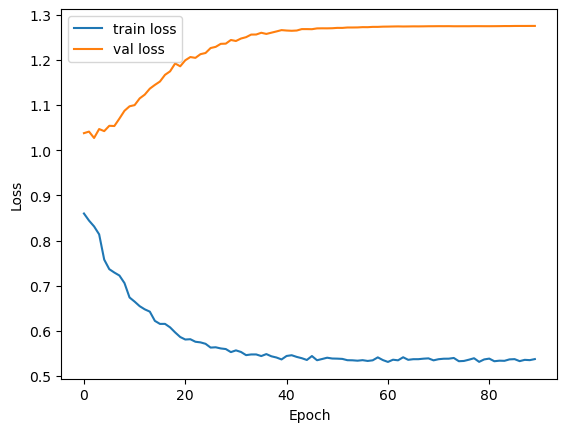

In [5]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'][10:], label='train loss')
plt.plot(history.history['val_loss'][10:], label='val loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6536 - loss: 1.2842
Test accuracy: 0.6535999774932861


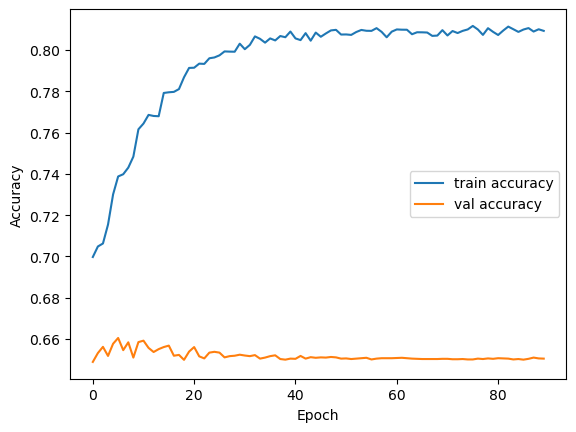

In [6]:
plt.plot(history.history['accuracy'][10:], label='train accuracy')
plt.plot(history.history['val_accuracy'][10:], label='val accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
test_loss, test_acc = model.evaluate(
    features_test,
    keras.utils.to_categorical(y_test, num_classes=10)
)
print("Test accuracy:", test_acc)


Mielenkiintoisesti validation accuracy ei tunnu kasvavan, vaikka training accuracy kasvaa. Lopullinen tarkkuus on n. 65 %, kun testataan testidatalla. Tämä saattaa osittain johtua siitä, että selvittelyn jälkeen tämä esiopetettu malli on koulutettu huomattavasti suuriresoluutioisemmilla kuvilla kuin mitä CIFAR-10 datasetissä on.